# Select a nice subset of data and remove NaNs

In [1]:
from pathlib import Path
import shutil
import numpy as np
import matplotlib.pyplot as plt

In [2]:
plt.rc("figure", dpi=100)

In [3]:
np.random.seed(0)

In [4]:
data_dir = Path("../data/raw/")
out_dir = Path("../data/temperature/")
out_dir.mkdir(exist_ok=True, parents=True)

In [5]:
data_files = sorted(data_dir.glob("*.txt"))
print(len(data_files))

233


In [6]:
data = {}
for data_file in data_files:
    with open(data_file, encoding="latin1") as file_pointer:
        for line in file_pointer:
            if "Estimated Jan 1951-Dec 1980 absolute temperature (C):" in line:
                components = line.split(":")[1].split("+/-")
                assert len(components) == 2
                absolute_temperature = float(components[0])
                break
        else:
            raise ValueError(f"Abolute temperature not found for {data_file}")
        year, month, anomaly = np.loadtxt(
            file_pointer, 
            comments="%",
            usecols=[0, 1, 4],
            unpack=True,
        )
        temperature = anomaly + absolute_temperature
        time = year + 1 / 12 * (month - 1)
        data[data_file.name[:-4]] = (time, temperature)

In [7]:
data_recent = {}
start_year = 1940
for country in data:
    time, temperature = data[country]
    recent = (time >= start_year)
    # Last 6 months are absent because of the 1-year average
    recent[-6:] = False
    if not np.any(np.isnan(temperature[recent])):
        data_recent[country] = (time[recent], temperature[recent])
print(len(data_recent))

227


In [8]:
uk_time = data_recent["united-kingdom"][0]
for country in list(data_recent.keys()):
    time = data_recent[country][0]
    if time.shape != uk_time.shape or not np.allclose(uk_time, time):
        data_recent.pop(country)
print(len(data_recent))

176


In [9]:
selected_countries = sorted(np.random.choice(list(data_recent.keys()), size=30, replace=False))
assert set(data_recent).issuperset(selected_countries), f"Invalid countries: {set(selected_countries).difference(data_recent)}"

In [10]:
ndata = [data_recent[c][1][~np.isnan(data_recent[c][1])].size for c in selected_countries]
ndata

[966,
 966,
 966,
 966,
 966,
 966,
 966,
 966,
 966,
 966,
 966,
 966,
 966,
 966,
 966,
 966,
 966,
 966,
 966,
 966,
 966,
 966,
 966,
 966,
 966,
 966,
 966,
 966,
 966,
 966]

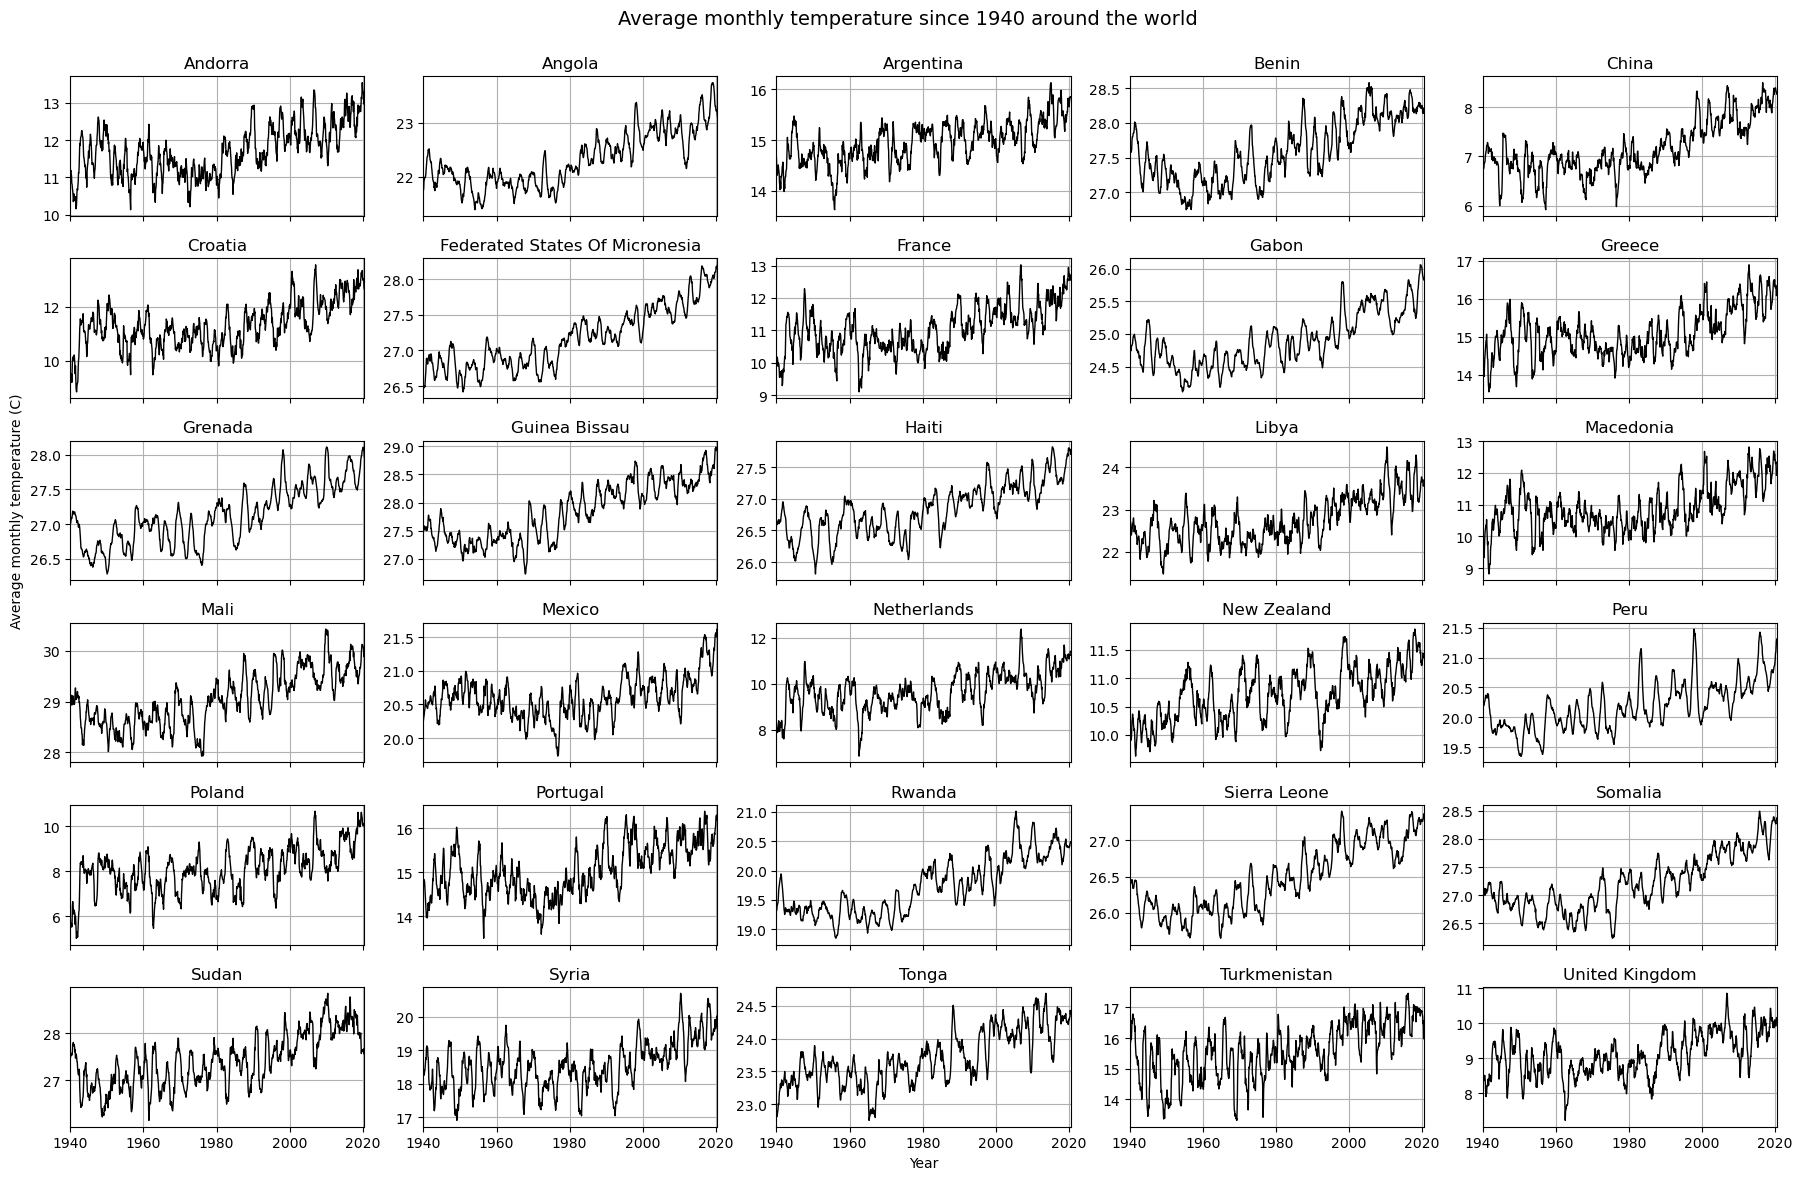

In [11]:
fig, axes = plt.subplots(6, 5, figsize=(18, 12), sharex=True)
fig.suptitle(f"Average monthly temperature since {start_year} around the world\n", size=14)
for country, ax in zip(selected_countries, axes.ravel()):
    time, temperature = data_recent[country]
    ax.set_title(country.replace("-", " ").title())
    ax.plot(time, temperature, "-k", linewidth=1)
    ax.set_xlim(time.min(), time.max())
    ax.grid()
axes[-1, 2].set_xlabel("Year")
axes[2, 0].set_ylabel("Average monthly temperature (C)")    
fig.tight_layout()

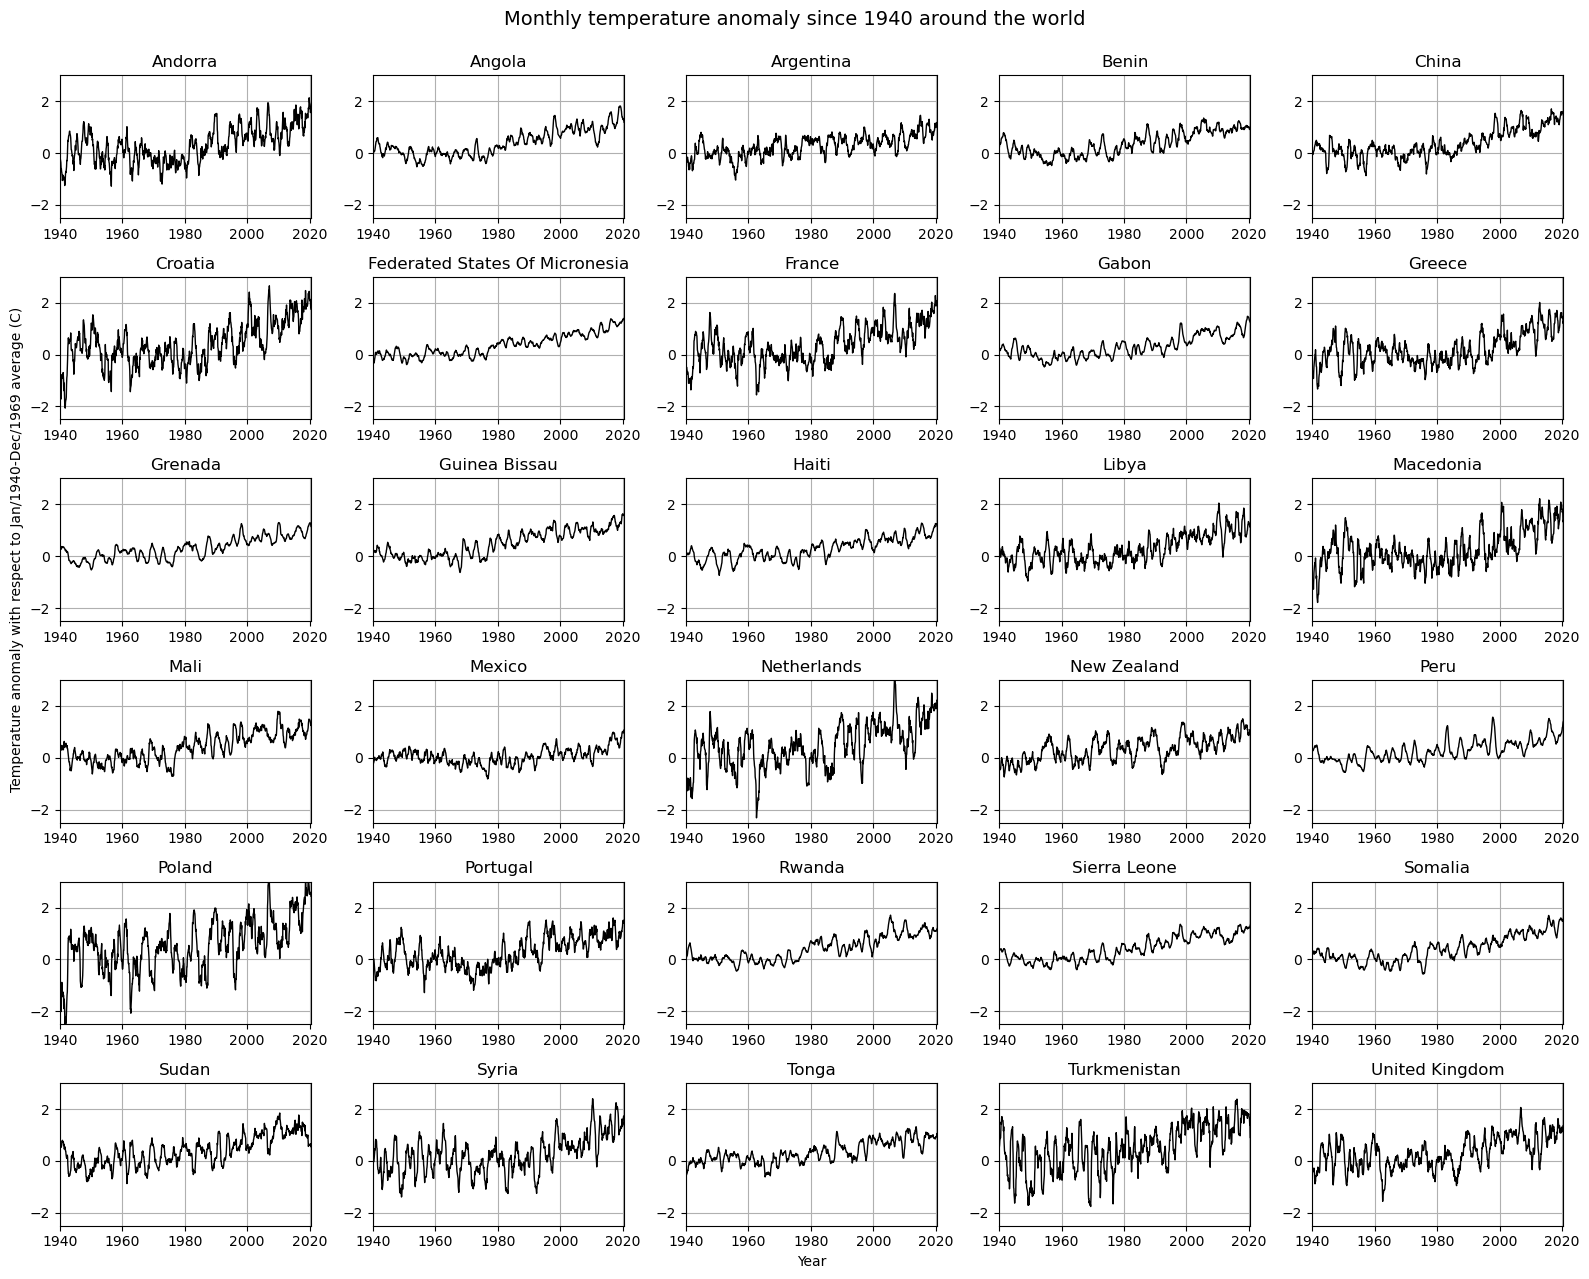

In [12]:
fig, axes = plt.subplots(6, 5, figsize=(16, 13))
fig.suptitle(f"Monthly temperature anomaly since {start_year} around the world\n", size=14)
for country, ax in zip(selected_countries, axes.ravel()):
    time, temperature = data_recent[country]
    average = np.mean(temperature[:12 * 30 + 1])
    anomaly = temperature - average
    ax.set_title(country.replace("-", " ").title())
    ax.plot(time, anomaly, "-k", linewidth=1)
    ax.set_xlim(time.min(), time.max())
    ax.set_ylim(-2.5, 3)
    ax.grid()
axes[-1, 2].set_xlabel("Year")
axes[2, 0].set_ylabel("Temperature anomaly with respect to Jan/1940-Dec/1969 average (C)")    
fig.tight_layout()
plt.savefig("temperature-anomaly-countries.png")

In [13]:
for country in selected_countries:
    np.savetxt(
        out_dir / f"{country}.csv",
        np.transpose(data_recent[country]),
        delimiter=",",
        fmt="%.3f",
    )

In [14]:
country_list = "\n".join([f"* {name.replace('-', ' ').title()}" for name in selected_countries])
readme = f"""
Monthly average temperature
---------------------------

This archive contains monthly average temperature records
since {start_year} for the following countries:

{country_list}

The data for each country is contained in a CSV file with 
columns: time, temperature (C)

The temperature is the country-wide average for each month 
of the year.

The time is a decimal year. This means that:

* 1940.000 = January 1940
* 1940.083 = February 1940
* 1941.000 = January 1941
* and so on

The data are a subset of the original data files from
Berkeley Earth (http://berkeleyearth.lbl.gov).
""".strip()

(out_dir / "README.txt").write_text(readme)

print(readme)

Monthly average temperature
---------------------------

This archive contains monthly average temperature records
since 1940 for the following countries:

* Andorra
* Angola
* Argentina
* Benin
* China
* Croatia
* Federated States Of Micronesia
* France
* Gabon
* Greece
* Grenada
* Guinea Bissau
* Haiti
* Libya
* Macedonia
* Mali
* Mexico
* Netherlands
* New Zealand
* Peru
* Poland
* Portugal
* Rwanda
* Sierra Leone
* Somalia
* Sudan
* Syria
* Tonga
* Turkmenistan
* United Kingdom

The data for each country is contained in a CSV file with 
columns: time, temperature (C)

The temperature is the country-wide average for each month 
of the year.

The time is a decimal year. This means that:

* 1940.000 = January 1940
* 1940.083 = February 1940
* 1941.000 = January 1941
* and so on

The data are a subset of the original data files from
Berkeley Earth (http://berkeleyearth.lbl.gov).


In [15]:
_ = shutil.make_archive(
    base_name=str(out_dir), 
    format="zip", 
    base_dir=out_dir.parts[-1], 
    root_dir=out_dir.parent
)